# TensorBoard Gamma Experiments Overlay

Notebook loads runs from a selected folder (default: `runs/cube_reinforcer/na_vse_babki`) and overlays all runs on the same chart for each metric.

Features:
- Runs are sorted by time (folder name).
- Gamma labels assigned in chronological phases: `1.0 -> 0.99 -> 0.95`.
- Background line: `train/scramble_steps_current`.
- Truncation: each run is cut at first transition to scramble depth `>= 4`.

In [3]:
from pathlib import Path
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

plt.style.use('seaborn-v0_8-whitegrid')

In [4]:
# ---- Config ----
RUNS_FOLDER_CANDIDATES = [
    Path('../runs/gammas'),
]

RUNS_FOLDER = None
for cand in RUNS_FOLDER_CANDIDATES:
    if cand.exists() and any(cand.glob('**/events.out.tfevents.*')):
        RUNS_FOLDER = cand
        break

if RUNS_FOLDER is None:
    print('No logs found in candidates:')
    for c in RUNS_FOLDER_CANDIDATES:
        print(' -', c.resolve())
    raise FileNotFoundError('No TensorBoard event logs found')

GAMMAS_IN_TIME_ORDER = [1.0, 0.99, 0.95]
# If None, runs are split equally across gamma phases.
# Example override: RUNS_PER_GAMMA = [3, 3, 3]
RUNS_PER_GAMMA = None

SCRAMBLE_TAG = 'train/scramble_steps_current'
SCRAMBLE_CUTOFF = 4
METRICS = [
    'train/sr_batch',
    'train/return_total_mean_batch',
    'train/reward_batch',  # if present
    'train/loss_batch',    # fallback legacy
    'train/steps_mean_batch',
    'train/steps_to_solve_mean_batch',
]

print('Using RUNS_FOLDER =', RUNS_FOLDER.resolve())

Using RUNS_FOLDER = /Users/vlad.sarm/Projects/RL_course/Cube-Reinforcer/runs/gammas


In [5]:
def load_scalars(run_dir: Path):
    ea = event_accumulator.EventAccumulator(str(run_dir))
    ea.Reload()
    tags = ea.Tags().get('scalars', [])
    out = {}
    for tag in tags:
        ev = ea.Scalars(tag)
        steps = np.array([e.step for e in ev], dtype=np.int64)
        vals = np.array([e.value for e in ev], dtype=np.float64)
        if steps.size:
            order = np.argsort(steps, kind='stable')
            steps, vals = steps[order], vals[order]
        out[tag] = (steps, vals)
    return out

def assign_gamma_labels(run_dirs, gammas, runs_per_gamma=None):
    n = len(run_dirs)
    if runs_per_gamma is None:
        # Equal split across phases
        base = n // len(gammas)
        rem = n % len(gammas)
        runs_per_gamma = [base + (1 if i < rem else 0) for i in range(len(gammas))]

    assert sum(runs_per_gamma) == n, f'sum(RUNS_PER_GAMMA)={sum(runs_per_gamma)} must equal num_runs={n}'

    labels = []
    idx = 0
    for g, cnt in zip(gammas, runs_per_gamma):
        for _ in range(cnt):
            labels.append(g)
            idx += 1
    return labels

def first_cutoff_step(scalars, scramble_tag=SCRAMBLE_TAG, cutoff=SCRAMBLE_CUTOFF):
    if scramble_tag not in scalars:
        return None
    s, v = scalars[scramble_tag]
    if s.size == 0:
        return None
    mask = v >= cutoff
    if not np.any(mask):
        return None
    return int(s[np.argmax(mask)])

def trim_and_normalize(steps, values, cutoff_step=None):
    if steps.size == 0:
        return steps, values
    if cutoff_step is not None:
        keep = steps < cutoff_step  # cut at transition to 4
        steps, values = steps[keep], values[keep]
    if steps.size == 0:
        return steps, values
    return steps - steps.min(), values

def display_metric_name(tag):
    return tag.replace('loss', 'reward')

In [6]:
event_files = sorted(RUNS_FOLDER.glob('**/events.out.tfevents.*'))
run_dirs = sorted({f.parent for f in event_files}, key=lambda p: p.name)
assert run_dirs, f'No event files found under: {RUNS_FOLDER}'

gamma_labels = assign_gamma_labels(run_dirs, GAMMAS_IN_TIME_ORDER, RUNS_PER_GAMMA)

runs = []
for rd, gamma in zip(run_dirs, gamma_labels):
    scalars = load_scalars(rd)
    cutoff = first_cutoff_step(scalars)
    runs.append({
        'run_dir': rd,
        'run_name': rd.name,
        'gamma': gamma,
        'cutoff_step': cutoff,
        'scalars': scalars,
    })

print(f'Loaded {len(runs)} runs from {RUNS_FOLDER}')
for i, r in enumerate(runs, 1):
    print(f"{i:2d}. {r['run_name']} | gamma={r['gamma']} | cutoff_step={r['cutoff_step']}")

Loaded 3 runs from ../runs/gammas
 1. run_20260218_165238 | gamma=1.0 | cutoff_step=923
 2. run_20260218_175100 | gamma=0.99 | cutoff_step=1021
 3. run_20260218_175739 | gamma=0.95 | cutoff_step=2114


In [7]:
# Determine metrics available in at least one run
available_metrics = []
for m in METRICS:
    if any(m in r['scalars'] for r in runs):
        available_metrics.append(m)

print('Metrics to plot:')
for m in available_metrics:
    print(' -', m)

Metrics to plot:
 - train/sr_batch
 - train/return_total_mean_batch
 - train/loss_batch
 - train/steps_mean_batch
 - train/steps_to_solve_mean_batch


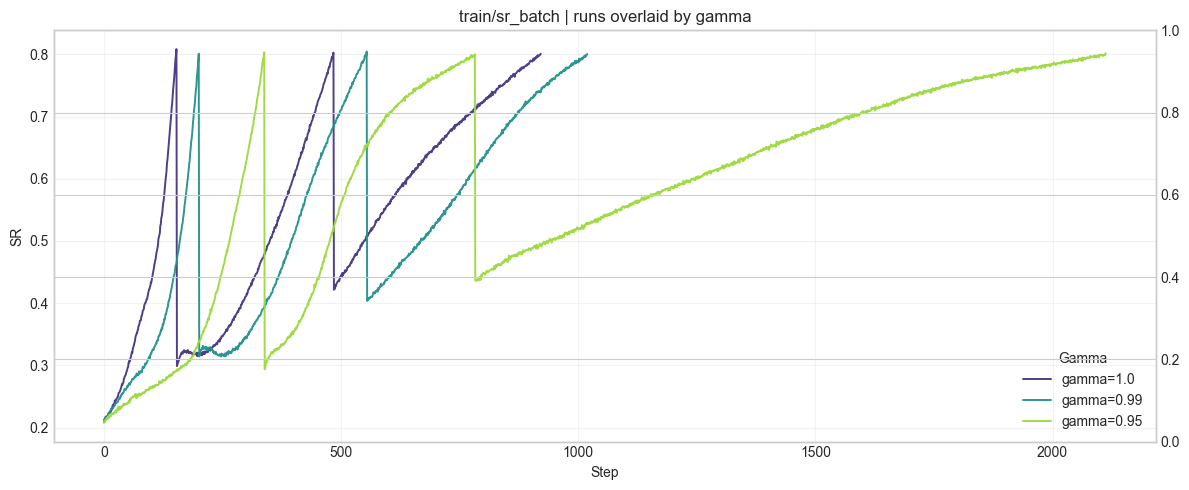

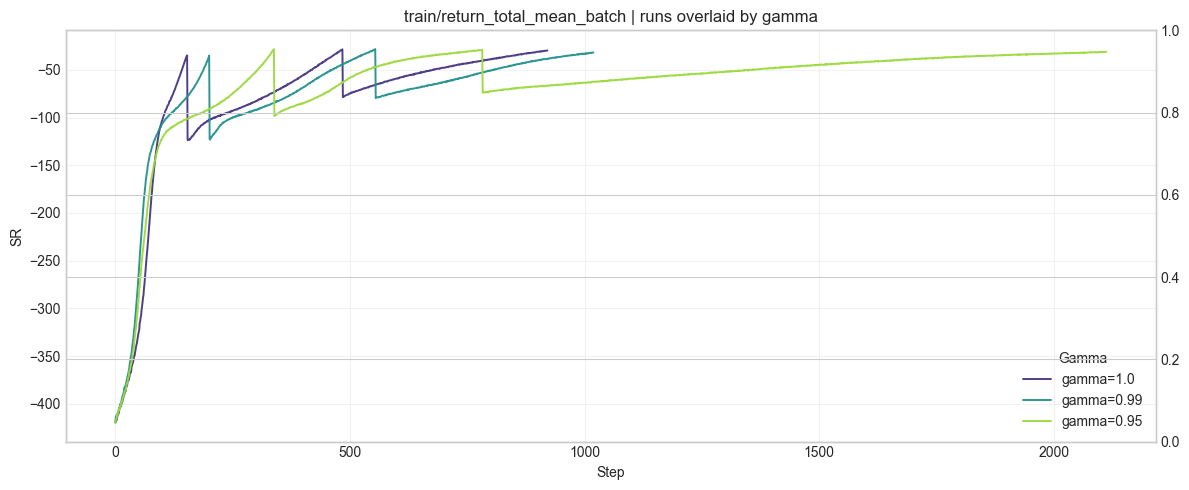

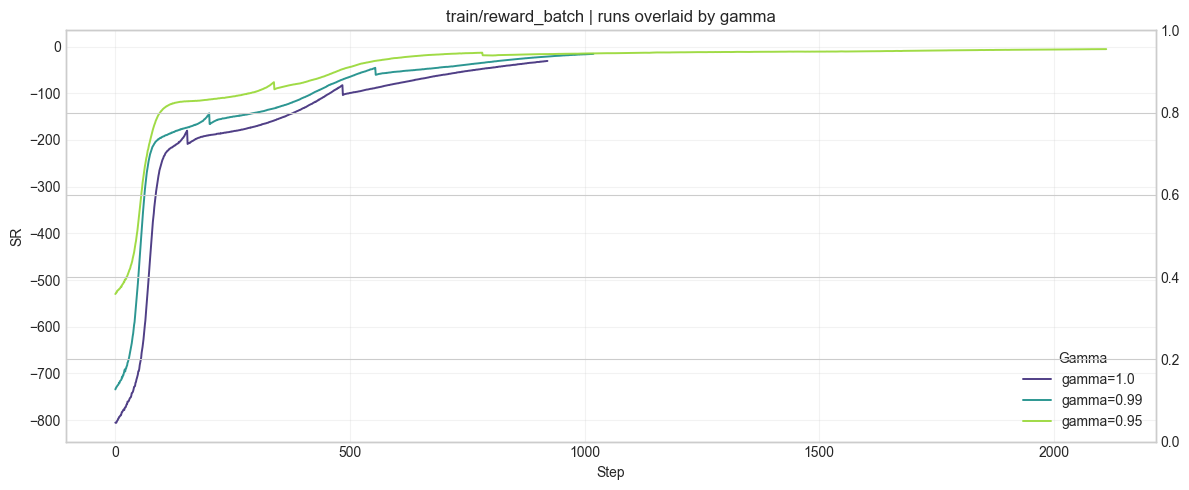

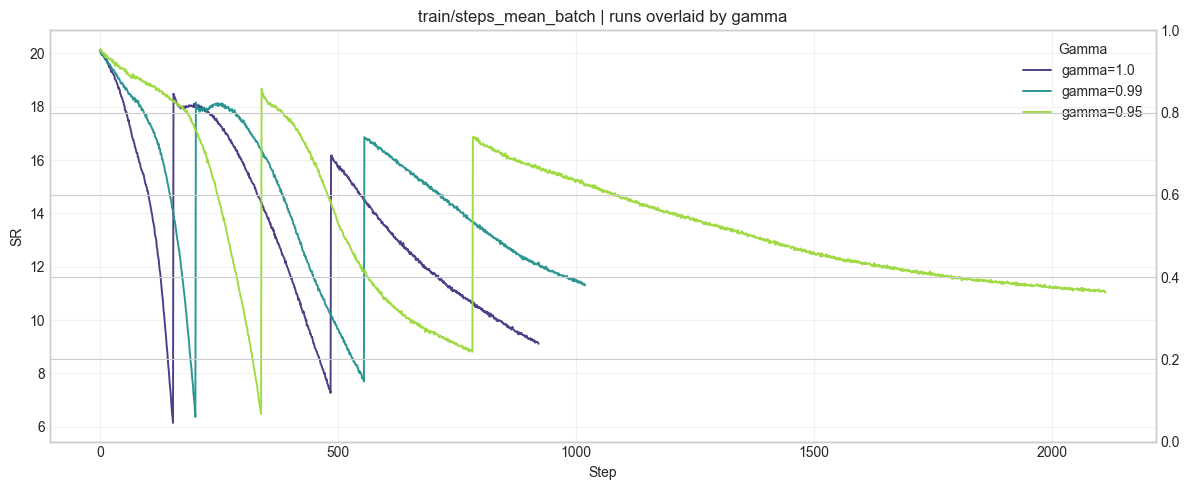

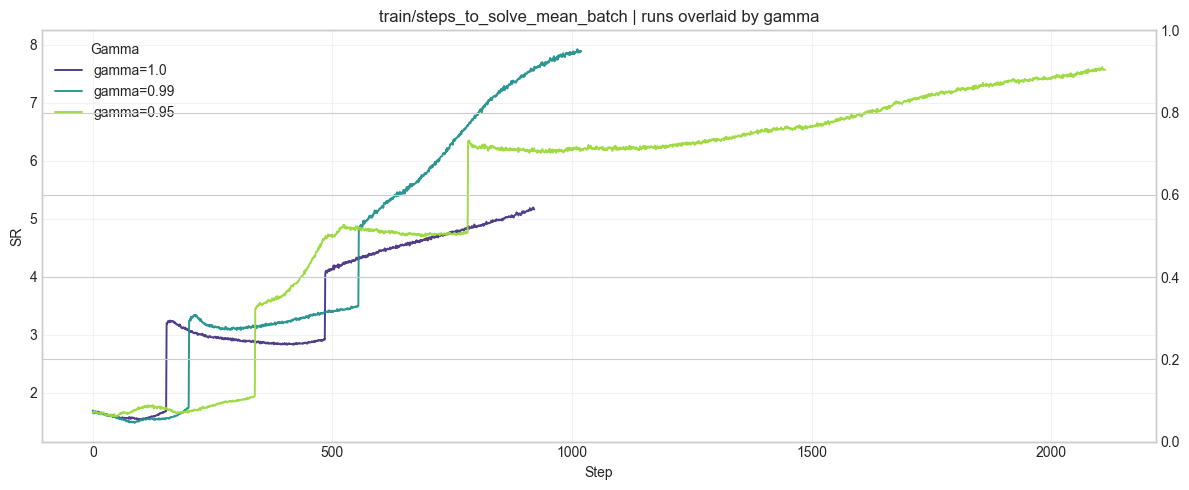

In [17]:
# Color by gamma (stable palette)
unique_gammas = list(OrderedDict.fromkeys([r['gamma'] for r in runs]))
palette = plt.cm.viridis(np.linspace(0.15, 0.85, len(unique_gammas)))
gamma_to_color = {g: palette[i] for i, g in enumerate(unique_gammas)}

for metric in available_metrics:
    fig, ax = plt.subplots(figsize=(12, 5))
    ax_bg = ax.twinx()

    # Background: scramble steps current (gray)
    for r in runs:
        if SCRAMBLE_TAG not in r['scalars']:
            continue
        s_bg, v_bg = r['scalars'][SCRAMBLE_TAG]
        s_bg, v_bg = trim_and_normalize(s_bg, v_bg, cutoff_step=r['cutoff_step'])
        if s_bg.size == 0:
            continue
        # ax_bg.plot(s_bg, v_bg, color='red', alpha=0.35, linewidth=2.0, zorder=2)

    # Foreground: metric per run, colored by gamma
    seen_gamma = set()
    for r in runs:
        if metric not in r['scalars']:
            continue
        s, v = r['scalars'][metric]
        s, v = trim_and_normalize(s, v, cutoff_step=r['cutoff_step'])
        if s.size == 0:
            continue

        g = r['gamma']
        label = f'gamma={g}' if g not in seen_gamma else None
        seen_gamma.add(g)
        ax.plot(s, v, color=gamma_to_color[g], linewidth=1.4, alpha=0.95, label=label, zorder=3)

    ax.set_title(display_metric_name(metric) + ' | runs overlaid by gamma')
    ax.set_xlabel('Step')
    ax.set_ylabel('SR')
    ax.grid(True, alpha=0.25)

    # ax_bg.set_ylabel('train/scramble_steps_current (background)', color='red')
    # ax_bg.tick_params(axis='y')
    # ax_bg.set_ylim(bottom=0)

    # Combined legend
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='best', title='Gamma')

    plt.tight_layout()
    plt.show()